In [2]:
# Model calling and intial setup
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_openai import AzureChatOpenAI
from dotenv import load_dotenv
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser 
import warnings
warnings.filterwarnings("ignore") 

load_dotenv()
# Load env
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
AZURE_BASE_URL = os.getenv("AZURE_BASE_URL")
AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_CHAT_DEPLIOYMENT_NAME = os.getenv("AZURE_CHAT_DEPLIOYMENT_NAME")

parser = StrOutputParser()

llm_gemini = ChatGoogleGenerativeAI(model="gemini-2.0-flash" , api_key= GOOGLE_API_KEY)

llm_openai = AzureChatOpenAI(
    model="gpt-4o-mini",                         
    deployment_name=AZURE_CHAT_DEPLIOYMENT_NAME ,  # deployment name in Azure
    api_key=AZURE_OPENAI_API_KEY,
    azure_endpoint=AZURE_BASE_URL,
    api_version="2024-02-01"
    )
llm_openai.invoke("What are your creater, also what type of LLM are you").content
# llm_gemini.invoke("who is father of india").content

"I was created by OpenAI, and I am based on the GPT-3.5 architecture, which is a type of large language model (LLM). My design allows me to understand and generate text based on the input I receive, enabling a wide range of applications, from answering questions to engaging in conversation. If you have any specific questions or topics you'd like to discuss, feel free to ask!"

In [ ]:
# Import LannGrapgh
from langgraph.graph import StateGraph , START , END
from typing import TypedDict

# Calculate BMI Flow State
class BMISate(TypedDict):
    weight : float
    heigh_m : float
    bmi : float
    
# Helper fucntion
def cal_bmi(state:BMISate)->BMISate:
    bmi = state.get('weight') / (state.get('heigh_m') **2 )
    
    state['bmi'] = round(bmi, 4)
    
    return state

# Define grapgh
graph = StateGraph(BMISate)

# Add Node
graph.add_node("Calculate_BMI", cal_bmi)

# Add Edges
graph.add_edge(START , "Calculate_BMI")
graph.add_edge("Calculate_BMI" , END)

first_workflow = graph.compile()


In [14]:
intial_state = {"weight" : 87 , "heigh_m" : 1.70}
final_state = first_workflow.invoke(intial_state)
final_state

{'weight': 87, 'heigh_m': 1.7, 'bmi': 30.1038}

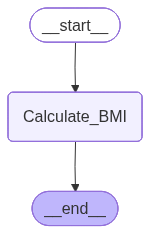

In [15]:
from IPython.display import Image
Image(first_workflow.get_graph().draw_mermaid_png())

In [ ]:
# According to bmi add a lable

# Import LannGrapgh
from langgraph.graph import StateGraph , START , END
from typing import TypedDict

# Calculate BMI Flow State
class BMISate(TypedDict):
    weight : float
    heigh_m : float
    bmi : float
    bmi_label : str
    
# Helper fucntion
def cal_bmi(state:BMISate)->BMISate:
    bmi = state.get('weight') / (state.get('heigh_m') **2 )
    
    state['bmi'] = round(bmi, 4)
    
    return state

def label_bmi(state:BMISate)->BMISate:
    bmi_lable = "healthy" if state['bmi'] <28.0 else "over-weight"
    
    state['bmi_label'] = bmi_lable
    
    return state

# Define grapgh
graph = StateGraph(BMISate)

# Add Node
graph.add_node("Calculate_BMI", cal_bmi)
graph.add_node("BMI_Labelling" , label_bmi)

# Add Edges
graph.add_edge(START , "Calculate_BMI")
graph.add_edge('Calculate_BMI' ,'BMI_Labelling')
graph.add_edge("BMI_Labelling" , END)

first_workflow = graph.compile()

In [17]:
intial_state = {"weight" : 87 , "heigh_m" : 1.70}
final_state = first_workflow.invoke(intial_state)
final_state

{'weight': 87, 'heigh_m': 1.7, 'bmi': 30.1038, 'bmi_label': 'over-weight'}

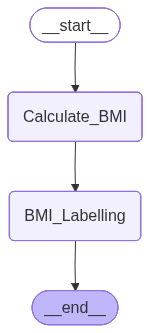

In [19]:
from IPython.display import Image
Image(first_workflow.get_graph().draw_mermaid_png())

#### LLM Based workflow

In [ ]:
# Import LannGrapgh
from langgraph.graph import StateGraph , START , END
from typing import TypedDict

# GET QA state 
class QAState(TypedDict):
    ques : str
    ans : str
    
def get_ans(state:QAState)->QAState:
    ans = llm_gemini.invoke(state['ques']).content
    state['ans'] = ans
    return state

# Define grapgh
graph = StateGraph(QAState)

# Add Node
graph.add_node("Give_Ans", get_ans)

# Add Edges
graph.add_edge(START , "Give_Ans")
graph.add_edge("Give_Ans" , END)

llm_workflow = graph.compile()

In [26]:
llm_workflow.invoke({"ques" : "what is name of Indian Pm"})

{'ques': 'what is name of Indian Pm',
 'ans': 'The current Prime Minister of India is Narendra Modi.'}

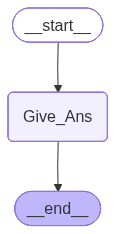

In [27]:
from IPython.display import Image
Image(llm_workflow.get_graph().draw_mermaid_png())

### Promt Chaining Workflow

In [36]:
# GET Blog Generation State
class BlogState(TypedDict):
    topic : str
    outline : str
    blog :str
    summary : str
    
def get_outline(state:BlogState)->QAState:
    promt = PromptTemplate(
        template="You're Subject matter Expert on the {topic}, Using all the resource you have generate a good outline to write a blog on {topic}. From starting to main part to Ending genarte a compehansive outline for the same",
        input_variables=['topic']
    )
    # Create Chain
    outline_chain = promt | llm_openai | parser
    
    # Invoke chain
    outline = outline_chain.invoke({"topic" : state['topic'] })
    state['outline'] = outline
    
    return state
\
def get_blog(state:BlogState)->QAState:
    prompt = PromptTemplate(
        template="You're a Blog writter, Insprired from the modern Blog writing, you have to write a 300-500 word blog on the topic of {topic}, with the outline that is already give to you: \n {outline}. Make no mistake and factual Error",
        input_variables=['topic' , 'outline']
    )
    
    # Creating Chains
    blog_chain = prompt | llm_openai | parser
    # Invoke chain
    blog = blog_chain.invoke({'topic': state['topic'], 'outline': state['outline']})
    state['blog'] = blog
    return state

def get_summary(state:BlogState)->QAState:
    prompt = PromptTemplate(
        template=" You have got the following Blog, make a small summary of this blog that capture essensce of that blog, make summary between 100-150 words, THis is the blog : \n {blog}",
        input_variables= ['blog']
    )
    
    # Create Chains
    summary_chain = prompt | llm_openai | parser
    
    # Invoke the chains
    summary = summary_chain.invoke({"blog" : state['blog']})
    state['summary'] = summary
    return state

# Define grapgh
graph = StateGraph(BlogState)

# Add Node
graph.add_node("Get_Outline", get_outline)
graph.add_node("Get_Blog" , get_blog)
graph.add_node("Get_Summary", get_summary)

# Add Edges
graph.add_edge(START , "Get_Outline")
graph.add_edge("Get_Outline" , "Get_Blog")
graph.add_edge("Get_Blog" , 'Get_Summary')
graph.add_edge("Get_Summary" , END)

blog_workflow = graph.compile()

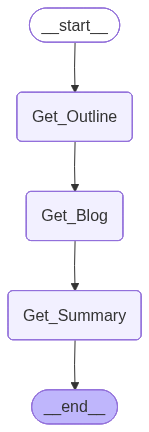

In [38]:
Image(blog_workflow.get_graph().draw_mermaid_png())

In [39]:
input_state = {"topic" : "State of Muslims in India, Under BJP Regim"}
output_state = blog_workflow.invoke(input=input_state)
output_state

{'topic': 'State of Muslims in India, Under BJP Regim',
 'outline': 'Certainly! Here’s a comprehensive outline for a blog on the state of Muslims in India under the BJP regime. This outline will help in organizing your thoughts and ensuring a thorough exploration of the topic.\n\n### Outline for Blog: "The State of Muslims in India Under the BJP Regime"\n\n---\n\n#### **1. Introduction**\n   - **1.1 Contextual Background**\n     - Brief overview of the BJP (Bharatiya Janata Party) and its rise to power in India.\n     - Historical context of Muslims in India.\n   - **1.2 Significance of the Issue**\n     - Why the state of Muslims is a critical issue in understanding contemporary India.\n   - **1.3 Objectives of the Blog**\n     - To explore the policies, societal impacts, and lived experiences of Muslims in India under the BJP.\n\n#### **2. Historical Context**\n   - **2.1 Muslims in Pre-Independence India**\n     - Historical struggles and contributions of Muslims in shaping Indian s

In [40]:
print(output_state['outline'])

Certainly! Here’s a comprehensive outline for a blog on the state of Muslims in India under the BJP regime. This outline will help in organizing your thoughts and ensuring a thorough exploration of the topic.

### Outline for Blog: "The State of Muslims in India Under the BJP Regime"

---

#### **1. Introduction**
   - **1.1 Contextual Background**
     - Brief overview of the BJP (Bharatiya Janata Party) and its rise to power in India.
     - Historical context of Muslims in India.
   - **1.2 Significance of the Issue**
     - Why the state of Muslims is a critical issue in understanding contemporary India.
   - **1.3 Objectives of the Blog**
     - To explore the policies, societal impacts, and lived experiences of Muslims in India under the BJP.

#### **2. Historical Context**
   - **2.1 Muslims in Pre-Independence India**
     - Historical struggles and contributions of Muslims in shaping Indian society.
   - **2.2 Post-Independence Developments**
     - Initial policies regarding 

In [41]:
print(output_state['blog'])

### The State of Muslims in India Under the BJP Regime

#### Introduction

Since its rise to power in 2014, the Bharatiya Janata Party (BJP) has significantly influenced the socio-political landscape of India. With roots in Hindutva ideology, which promotes a vision of India as primarily a Hindu nation, the party's policies and rhetoric have raised critical questions about the state of Muslims in India. Muslims, who constitute approximately 14% of the Indian population, have historically played a vital role in the country's cultural, social, and political fabric. Thus, understanding their current status is essential for grasping the complexities of contemporary Indian society.

#### Historical Context

To appreciate the present, one must acknowledge the historical significance of Muslims in India. From the Mughal Empire's contributions to the freedom struggle against colonial rule, Muslims have been integral to India's identity. Post-independence, the Indian Constitution enshrined prin

In [42]:
print(output_state['summary'])

The blog "The State of Muslims in India Under the BJP Regime" delves into the socio-political challenges faced by Muslims in India since the Bharatiya Janata Party (BJP) came to power in 2014. Rooted in Hindutva ideology, the BJP has fostered a polarized political landscape, often portraying Muslims as outsiders and heightening societal divisions. Key policies like the Citizenship Amendment Act (CAA) and the National Register of Citizens (NRC) have raised concerns of systemic discrimination, while communal tensions and economic disparities have increased. By sharing personal narratives and emphasizing the need for inclusive dialogue, the blog advocates for a collective commitment to uphold India’s secular and pluralistic essence, calling for unity and social justice to ensure a more equitable society for all citizens.
